In [2]:
# system
import os
from datetime import datetime
from datetime import timedelta

# data processing and plotting
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yahooFinance

# ml/dl
from pmdarima import auto_arima, AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

# trd
import MetaTrader5 as mt

---
# Download data

In [88]:
mt.initialize()
mt.login(152702909, open('../.pass', 'r').read().strip(), 'Exness-MT5Trial')
df = pd.DataFrame(mt.copy_rates_range('BTCUSD', mt.TIMEFRAME_D1, datetime(2023, 1, 1), datetime.now()))
mt.shutdown()

True

In [89]:
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1672531200,16532.88,16619.48,16492.71,16603.49,79688,427,0
1,1672617600,16602.97,16773.48,16535.88,16665.66,82223,747,0
2,1672704000,16665.36,16773.61,16593.15,16662.49,82161,575,0
3,1672790400,16661.05,16988.17,16639.02,16837.79,83272,371,0
4,1672876800,16839.31,16868.59,16750.72,16814.80,82185,517,0


---
# Auxiliary

In [5]:
def tm_plot(dt, data, title='', xlabel='', ylabel='', figsize=(10, 7), style='fivethirtyeight'):
    # plt.style.use(style)
    plt.figure(figsize=figsize)
    plt.plot(dt, data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [119]:
def tm_rolling_forecast(df_train: pd.DataFrame, n_periods: int = 1, order: tuple = None, signal_only: bool = False) -> pd.Series:
    # train the model
    model = ARIMA(df_train, order=order).fit() if order else AutoARIMA(
        trace=False, 
        error_action='ignore', 
        suppress_warnings=True
    ).fit(y=df_train, x=df_train)
    
    # predict
    if order: y_pred = model.get_forecast(steps=n_periods, signal_only=signal_only)
    else: y_pred = model.predict(n_periods=n_periods)
    
    return y_pred.predicted_mean if order else y_pred


---
# Preprocess data

In [90]:
dfs = df.copy()

In [91]:
dfs.time = pd.to_datetime(df.time, unit='s', utc=False)
dfs.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2023-01-01,16532.88,16619.48,16492.71,16603.49,79688,427,0
1,2023-01-02,16602.97,16773.48,16535.88,16665.66,82223,747,0
2,2023-01-03,16665.36,16773.61,16593.15,16662.49,82161,575,0
3,2023-01-04,16661.05,16988.17,16639.02,16837.79,83272,371,0
4,2023-01-05,16839.31,16868.59,16750.72,16814.80,82185,517,0


In [92]:
dfi = dfs.set_index('time')
dfi.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2023-01-01,16532.88,16619.48,16492.71,16603.49,79688,427,0
2023-01-02,16602.97,16773.48,16535.88,16665.66,82223,747,0
2023-01-03,16665.36,16773.61,16593.15,16662.49,82161,575,0
2023-01-04,16661.05,16988.17,16639.02,16837.79,83272,371,0
2023-01-05,16839.31,16868.59,16750.72,16814.80,82185,517,0


---
# Analysis

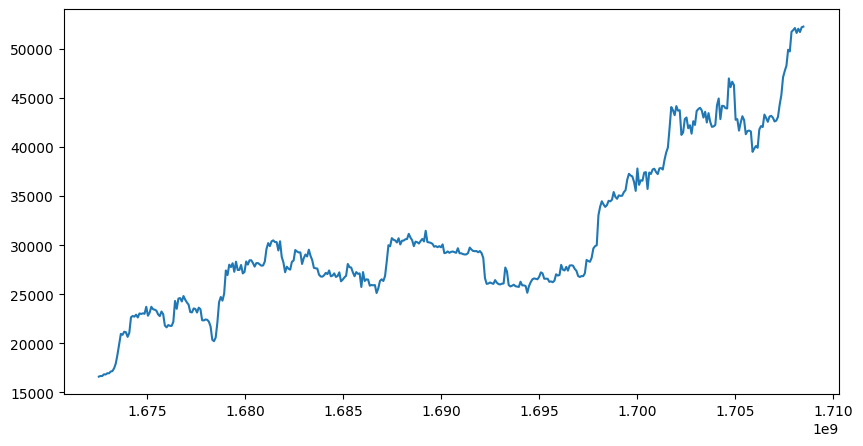

In [9]:
tm_plot(df.time, df.close, figsize=(10, 5))

<Figure size 640x480 with 0 Axes>

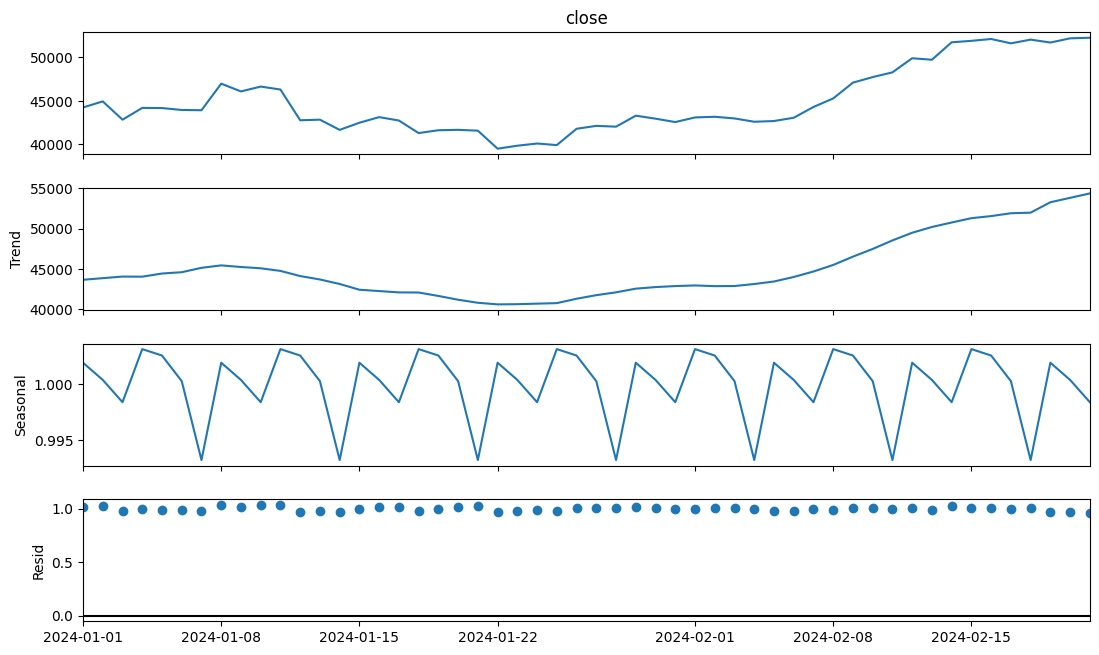

In [10]:
results = seasonal_decompose(dfi.loc[datetime(2024, 1, 1):].close, model='multiplicative', extrapolate_trend='freq')
fig = plt.figure()  
fig = results.plot()  
fig.set_size_inches(12, 7)
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

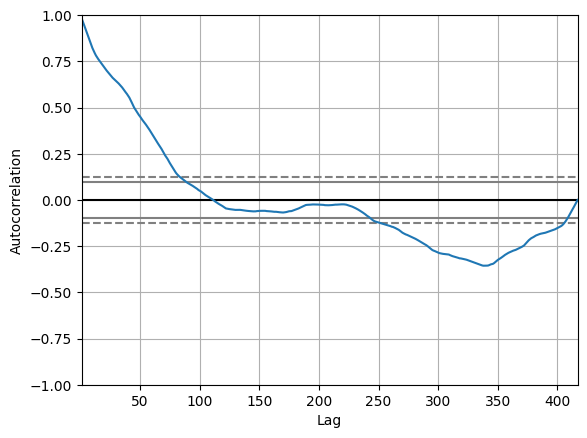

In [11]:
pd.plotting.autocorrelation_plot(dfi.close)

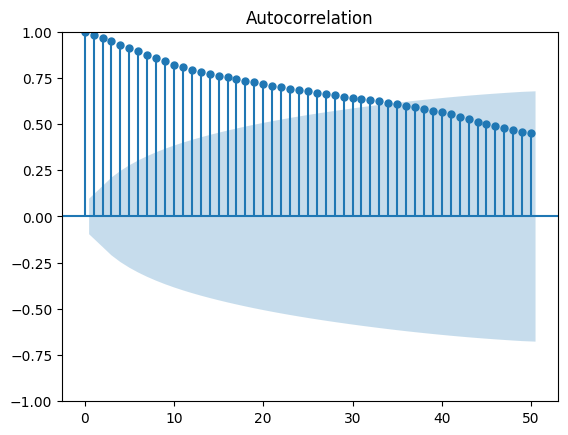

In [12]:
plot_acf(dfi.close, lags=50)
plt.show()

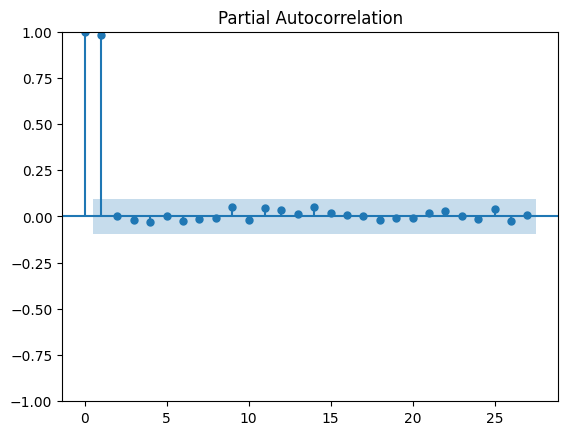

In [13]:
plot_pacf(dfi.close)
plt.show()

In [115]:
model = ARIMA(dfs.close, order=(1, 1, 1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  418
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3338.715
Date:                Sun, 25 Feb 2024   AIC                           6683.430
Time:                        09:20:01   BIC                           6695.529
Sample:                             0   HQIC                          6688.213
                                - 418                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.004    231.713      0.000       0.991       1.008
ma.L1         -0.9988      0.031    -31.834      0.000      -1.060      -0.937
sigma2      5.282e+05   2.87e-08   1.84e+13      0.0

In [120]:
y_preds = model.get_forecast(steps=3)
y_preds.predicted_mean

418    51542.192981
419    51617.529856
420    51692.860626
Name: predicted_mean, dtype: float64

In [123]:
tm_rolling_forecast(dfs.close, n_periods=3, order=(1, 1, 1), signal_only=True)

418    51542.192981
419    51617.529856
420    51692.860626
Name: predicted_mean, dtype: float64

In [124]:
model = AutoARIMA(
    trace = True,
    error_action ='ignore', 
).fit( 
    y=dfs.close,
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6683.529, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6679.669, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6680.741, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6680.878, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6683.187, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6682.521, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.279 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  418
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3337.835
Date:                Sun, 25 Feb 2024   AIC                           6679.669
Time:                        09:25:30   BIC                           6687.736
Sample:                             0   HQIC                          6682.858
          

In [126]:
model.predict(n_periods=3)

418    51550.45518
419    51634.06036
420    51717.66554
dtype: float64

In [127]:
tm_rolling_forecast(dfs.close, n_periods=3)

418    51550.45518
419    51634.06036
420    51717.66554
dtype: float64